Hemanth Chandravamsi, Feb 2023

# Numerical solution of blassius equation solved using RK4

## Governing equations and boundary conditions
The Blassius equation (a simplified version of the Prandtl's Boundary layer equations - cont, x-mom, and y-mom):

$$f''' + 0.5 f f'' = 0$, $\quad \text{or} \quad$ $\frac{\partial^3 f}{\partial \eta^3} + 0.5 f \frac{\partial^2 f}{\partial \eta^2} = 0$$

Initial and Boundary conditions:

$$f(\eta=0) = 0, \quad f'(\eta=0) = 0, \quad f'(\eta=\infty) = 1$$


## Split the governing equation
The above third order ODE can be split into three simple first order ODEs which are way simpler to solve together numerically.

assuming: $$f_0 = f, \quad f_1 = f', \quad f_2 = f''$$

We can say: $$f_0' = f', \quad f_1' = f'', \quad f_2' = f''' = -0.5ff''$$

ICs/BCs: $$f_0(0) = 0, \quad f_1(0) = 0, \quad f_1(\infty) = 1, \quad f_2(0) = ?$$ (We need to give $f_2(0)$ in such a way that the condition $f_1(\infty)$ will be satisfied)

## Numerical strategy to solve coupled set of three governing equations

* Our target is to find $f_0$, $f_1$ and $f_2$ numerically.
* For each of those, we have equations defined: $f_0' = f'$, $\quad$ $f_1' = f''$, $\quad$ $f_2' = f''' = -0.5ff''$
* Compute RHS value for each equation at $\eta_i$ and integrate it over time to get $\eta_{i+1}$ employing RK4.
* RHS value for 1st equation: RHS = $f'(\eta)=f_1(\eta)$
* RHS value for 2nd equation: RHS = $f''(\eta)=f_2(\eta)$
* RHS value for 3rd equation: RHS = $f'''(\eta)=-0.5f_0(\eta)f_2(\eta)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define parameters
Mj = 1.35
# Mj = 1.56392148
gamma = 1.4
TR = 4.0
delta = 0.05

In [3]:
# Define parameters
n = 1000
eta = np.linspace(0,7,n)
f = np.zeros((3,n)) # contains all f0, f1 and f2
h = eta[1]-eta[0]   # treat space like time here. We know values at eta = 0, we are interested in finding f at rest of the f values

In [4]:
# Initialize f[0], f[1], and f[2]
f[0,:] = 0
f[1,:] = 0
f[2,:] = 0.332

In [5]:
# Define functions to compute RHS
def RHS_eqn1(f):
    return f[1]

def RHS_eqn2(f):
    return f[2]

def RHS_eqn3(f):
    return -0.5*f[0]*f[2]

In [6]:
# Using RK4 compute f[0,i+1], f[1,i+1], and f[2,i+1]
for i in range(n-1):
    k1 = np.array([RHS_eqn1(f[:, i]),            RHS_eqn2(f[:, i]),              RHS_eqn3(f[:, i])])                # slope at i
    k2 = np.array([RHS_eqn1(f[:, i] + 0.5*h*k1), RHS_eqn2(f[:, i] + 0.5*h*k1),   RHS_eqn3(f[:, i] + 0.5*h*k1)])     # slope at i+1/2 (computed based on f_i and f_i+1 obtained from k1)
    k3 = np.array([RHS_eqn1(f[:, i] + 0.5*h*k2), RHS_eqn2(f[:, i] + 0.5*h*k2),   RHS_eqn3(f[:, i] + 0.5*h*k2)])     # slope at i+1/2 (computed based on f_i and f_i+1)
    k4 = np.array([RHS_eqn1(f[:, i] + h*k3),     RHS_eqn2(f[:, i] + h*k3),       RHS_eqn3(f[:, i] + h*k3)])         # slope at i+1
    f[:, i+1] = f[:, i] + (k1 + 2*k2 + 2*k3 + k4) * h/6

In [7]:
# Euler integration
# for i in range(n-1):
#     f[0, i+1] = f[0, i] +  h*RHS_eqn1(f[:, i])
#     f[1, i+1] = f[1, i] +  h*RHS_eqn2(f[:, i])
#     f[2, i+1] = f[2, i] +  h*RHS_eqn3(f[:, i])

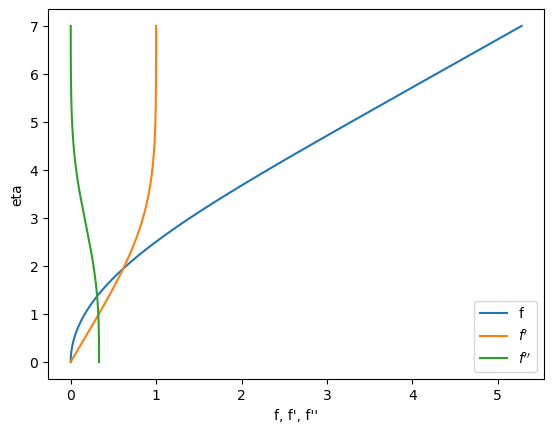

In [8]:
# Plot the results
plt.plot(f[0], eta, label='f')
plt.plot(f[1], eta, label='$f^{\prime}$')
plt.plot(f[2], eta, label='$f^{\prime \prime}$')
plt.xlabel("f, f', f''")
plt.ylabel("eta")
plt.legend()
plt.show()

0.9900440378635872


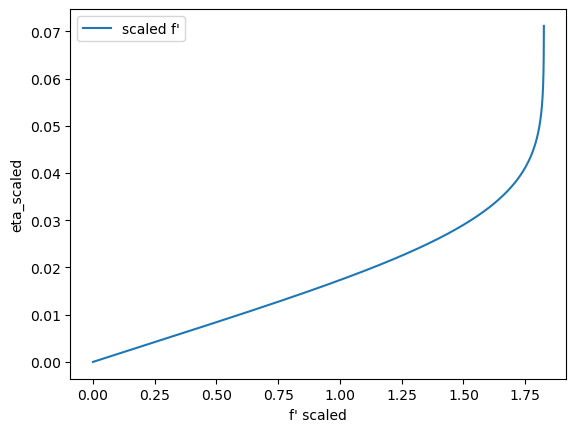

In [9]:
# Scale y axis to obtain delta_99 at eta = 0.075
# Also scale x-vel to obtain desired non-dim inlet velocity for the solver

# find index corresponding to delta_99
idx = (np.abs(f[1] - 0.99)).argmin()
print(f[1,idx])

# scale y-axis
eta_scaled = eta/(eta[idx]/delta)

# Scale x-vel
u_s_infty = np.sqrt(2*TR/(1.4+1))
g = np.zeros((1,n))
g[0,:] = f[1,:]*u_s_infty

plt.plot(g[0], eta_scaled, label="scaled f'")
plt.xlabel("f' scaled")
plt.ylabel("eta_scaled")
plt.legend()
plt.show()

[-2.89397066e+12  5.78510614e+10  1.71745846e+11 -3.12229166e+10
  2.32961003e+09 -8.03766318e+07  1.16455563e+06 -1.68305837e+04
  9.32812772e+01  5.94160793e+01  1.17886697e-04]


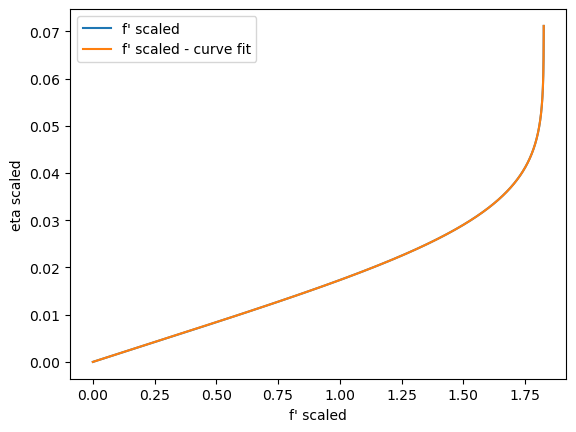

In [10]:
# Fit a polynomial in to that curve
coefficients = np.polyfit(eta_scaled, g[0], 10)
print(coefficients)
y_new = np.linspace(0, eta_scaled[n-1], 1000)
x_new = np.polyval(coefficients, y_new)
plt.plot(g[0], eta_scaled, label="f' scaled")
plt.plot(x_new, y_new, label="f' scaled - curve fit")
plt.xlabel("f' scaled")
plt.ylabel("eta scaled")
plt.legend()
plt.show()

# Crocco-Busemann profile for density

The temperature profile (and thus the density profile) is coupled to the velocity profile via the first Busemann–Crocco solution (equation shown below). If you consider the energy equation (compressible), neglect viscosity and heat diffusion terms (nviscid), and then integrate it, you get the following equation:

$$
C_p T_0 = C_p T + \frac{1}{2} u^2 \quad \Longrightarrow \quad \frac{T_0 - T(u)}{T_0} = \frac{u^2}{2 C_p T_0}
$$

Although this solution is strictly only valid for the plate boundary layer at $Pr = 1$, it is also a good approximation where pressure gradients do exist and for $Pr \ne 1$ (but $Pr ≈ 1$). This has been demonstrated in numerous comparisons with exact results.


### If $T$ and $u$ are non-dimensionalized with $T_{\infty}$ and $a_{\infty}$
For the MIGHTY solver the profiles are required to be non-dimensionalized. In this case non-dim based on freestream quantities
$$
T_s = TR - \frac{u_s^2 (\gamma-1)}{2} \quad \text{where: } T_s = \frac{T}{T_{\infty}} \text{ and } u_s = \frac{u}{a_{\infty}}
$$
Similarly:
$$
\rho_s = \frac{2 p_s \gamma}{2TR - u_s^2(\gamma-1)} \quad \text{where: } \rho_s = \frac{\rho}{\rho_{\infty}}
$$

We already know the relation for $p_s$ from isentropic relations (at $M=1$) for a given $M_j$ (ideally expanded jet Mach number corresponding to a given pressure ratio):
$$
p_s = \frac{p}{p_{\infty}}=\frac{1}{\gamma}\left[\frac{2+(\gamma-1) M_j^2}{\gamma+1}\right]^{\frac{\gamma}{\gamma-1}}
$$

rho_infty= 0.47032090577381996
T_infty= 3.3333333333333335


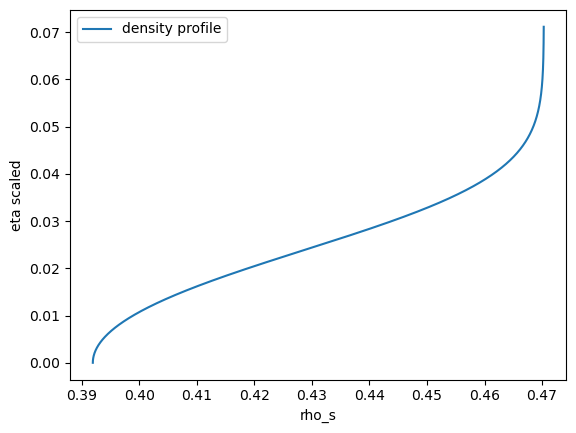

In [11]:
# first define pressure
p_s = 1/gamma*( (2+(gamma-1)*Mj**2)/(gamma+1) )**(gamma/(gamma-1))
print("rho_infty=", gamma*(gamma+1)*p_s/(2*TR))                     # print rho_infty
print("T_infty=", p_s*gamma/(gamma*(gamma+1)*p_s/(2*TR)))           # print T_infty

# use the above relationship between 'rho' and 'u' to find rho
rho_s = 2*p_s*gamma/(2*TR - g[0]**2*(gamma-1))

# use the above relationship between 'T' and 'u' to find T
T_s = TR - (g[0]**2)*(gamma-1)/2

plt.plot(rho_s, eta_scaled, label='density profile')
# plt.plot(T_s, eta_scaled)
plt.xlabel("rho_s")
plt.ylabel("eta scaled")
plt.legend()
plt.show()

[-4.41255899e+12  1.47247635e+12 -1.98576762e+11  1.36079165e+10
 -4.84173040e+08  8.18207178e+06 -6.90550046e+04  1.39970357e+02
  7.20761928e+01 -1.14194822e-02  3.91943031e-01]


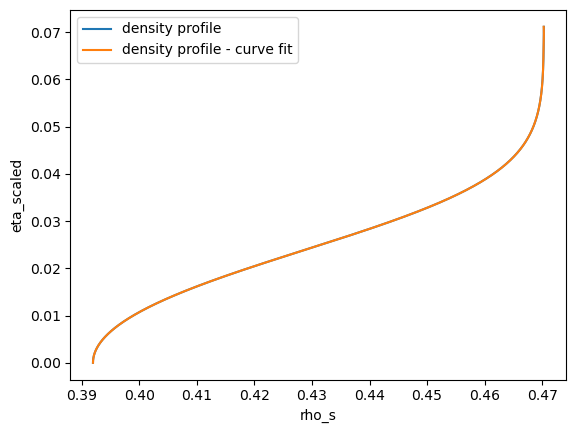

In [12]:
# fit a curve in to the density profile
coefficients = np.polyfit(eta_scaled, rho_s, 10)
print(coefficients)
y_new = np.linspace(0, eta_scaled[n-1], 1000)
x_new = np.polyval(coefficients, y_new)
plt.plot(rho_s, eta_scaled, label='density profile')
plt.plot(x_new, y_new, label="density profile - curve fit")
plt.xlabel("rho_s")
plt.ylabel("eta_scaled")
plt.legend()
plt.show()